## Fractional error as a function of distance

Run a short sampler chain. From here we can plot a histogram of the emulator call's Euclidean distance to the nearest training point. We can then also generate a plot of the fractional error as a function of distance from the nearest training point. Also would want to color points inside and outside the convex hull differently here.

The other way to do this would be to take an already-run sampler chain and run backwards through this. For each 'values' set, we can re-generate emulator predictions to find the fractional error and build up the Euclidean distance histogram. I like this way better I think, we can just load the chains and we don't have to run emcee. We can have the `distance` and `fractional_error` arrays outside of the sampler object which is probably cleaner.

Ok we go this way. So we need to load a set of chains. For n samples in this chain, we regenerate the emulator calls involved in each likelihood evaluation.

For each of these emulator calls, we can find the fractional error (pick some k, or do this for all k independently), and the distance to the nearest training point.

All this involves is using the `lya_theory` object for each set of likelihood values to return a list of emulator calls.

In [34]:
import numpy as np
import emcee_sampler
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [8]:
sampler = emcee_sampler.EmceeSampler(read_chain_file=3)
chain,lnprob=sampler.get_chain(cube=True)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Chain shape is  (235000, 6)


In [184]:
chains_to_test=500
frac_error=np.empty((chains_to_test,len(sampler.like.data.z),len(sampler.like.theory.emulator.training_k_bins)))
distance=np.empty((chains_to_test,len(sampler.like.data.z)))

In [185]:
for aa in range(chains_to_test):
    calls=sampler.like.get_emulator_calls(sampler.like.parameters_from_sampling_point(values=chain[aa]))
    for bb,call in enumerate(calls):
        distance[aa][bb]=sampler.like.theory.emulator.get_nearest_distance(call)
        pred,err=sampler.like.theory.emulator.emulate_p1d_Mpc(call,sampler.like.theory.emulator.training_k_bins,return_covar=True)
        frac=np.sqrt(np.diag(err))/pred
        for cc, element in enumerate(frac):
            frac_error[aa][bb][cc]=element

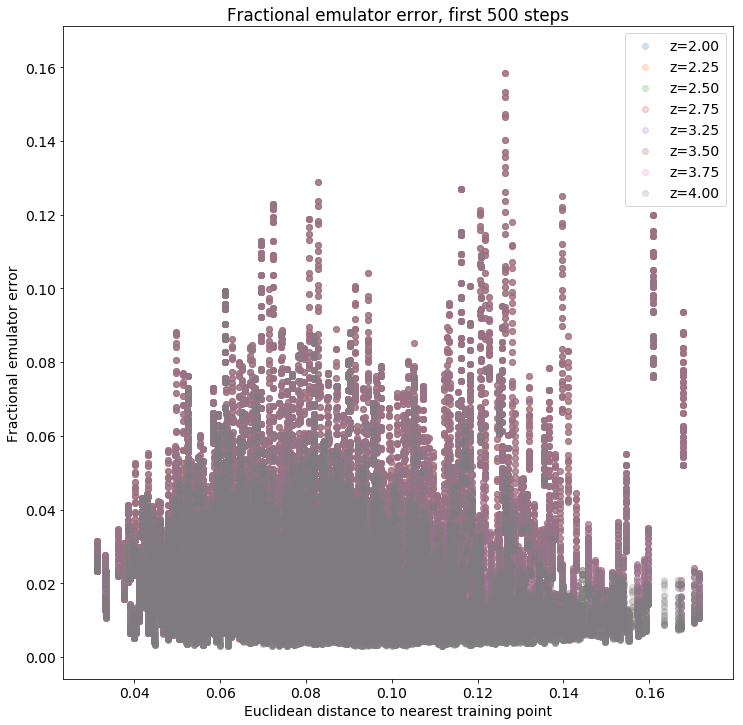

In [188]:
## Group by z
plt.figure(figsize=(12,12))
dist_plot=np.array([])
frac_plot=np.array([])
for aa,z in enumerate(sampler.like.data.z):
    ## Need a list of frac error along each z for each distance
    ## so we need lists of length len(kbin)*num_chains
    for bb in range(chains_to_test):
        for cc in range(len(sampler.like.theory.emulator.training_k_bins)):
            dist_plot=np.append(dist_plot,distance[bb,aa])
            frac_plot=np.append(frac_plot,frac_error[bb,aa,cc])
    plt.scatter(dist_plot,frac_plot,label="z=%.2f" % z,alpha=0.2)

plt.legend()
plt.title("Fractional emulator error, first 500 steps")
plt.xlabel("Euclidean distance to nearest training point")
plt.ylabel("Fractional emulator error")
plt.savefig("frac_error_first500.pdf")
    

    

In [189]:
dist_flat=distance.flatten()

In [190]:
frac_err_flat=frac_error.flatten()

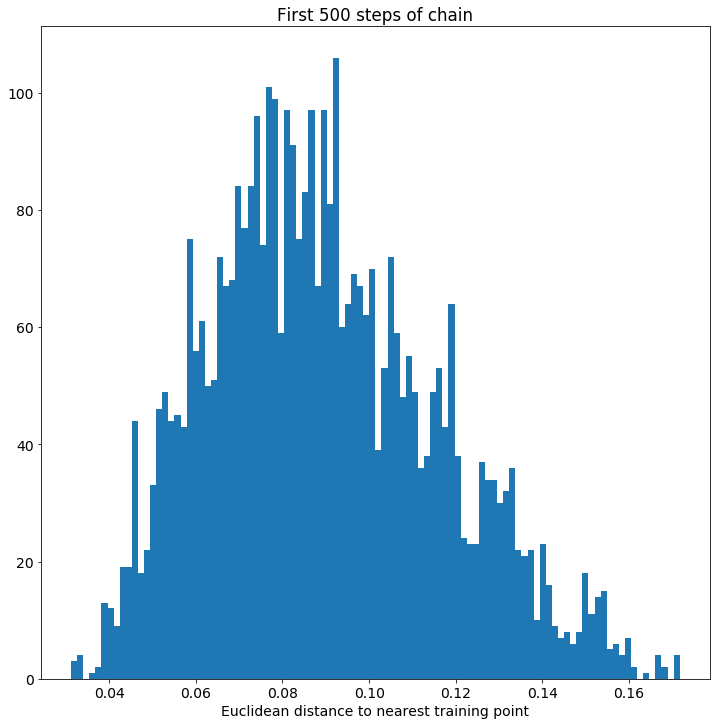

In [191]:
plt.figure(figsize=(12,12))
plt.title("First 500 steps of chain")
_=plt.hist(dist_flat,bins=100)
plt.xlabel("Euclidean distance to nearest training point")
plt.savefig("distance_first500.pdf")

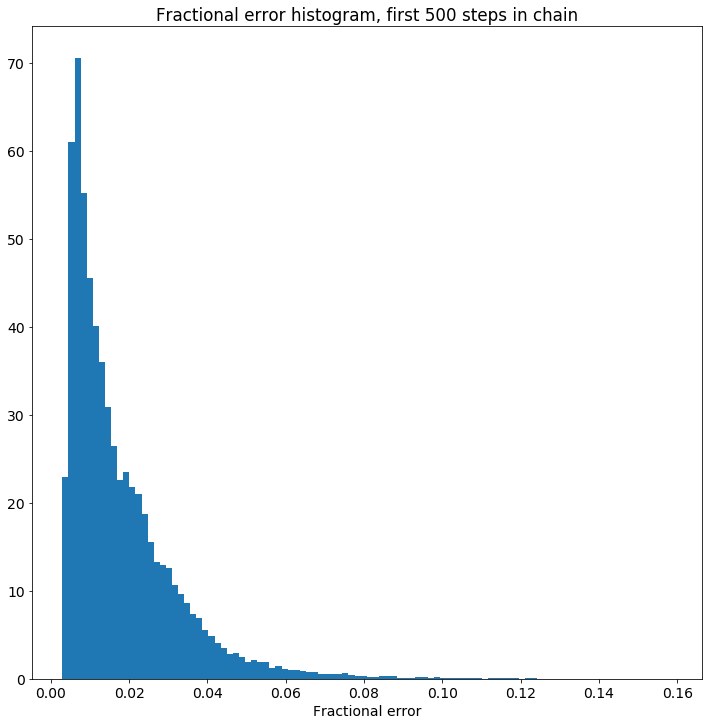

In [192]:
plt.figure(figsize=(12,12))
plt.title("Fractional error histogram, first 500 steps in chain")
_=plt.hist(frac_err_flat,bins=100,density="True")
plt.xlabel("Fractional error")
plt.savefig("fractional_error_first500.pdf")